Autorzy<br>
Jan Odważny<br>
Maksym Pata

#### Potrzebne biblioteki (instalacja wyjaśniona w README)

In [55]:
import cv2
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import pydicom

import numpy as np

# DICOM file compatibility
from pydicom.dataset import Dataset, FileDataset
import pydicom._storage_sopclass_uids
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

#### Wczytanie obrazu w formacie JPEG
Funkcja `choose_file()`, korzystająca z biblioteki Tkinter, wyświetla okienko z możliwością wyboru obrazu w formacie JPEG. Obraz ten jest czytany z pomocą biblioteki OpenCV i zapisywany w zmiennej `img`. Następnie, obraz podlega skalowaniu do rozmiarów 256x256 pikseli oraz następuje jego normalizacja i zamiana mapy kolorów z RGB na grayscale (skalę szarości). W końcowym przetwarzaniu nadawany jest obrazowi padding przy pomocy funkcji `add_padding()`. Wybrany obraz oraz obraz z nadanym paddingiem jest wyświetlany na dwóch osobnych wykresach.

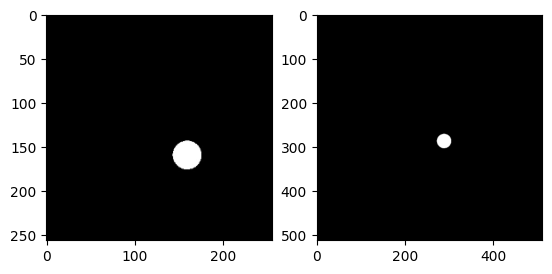

In [56]:
# Function to add padding to image
def add_padding(image, color=(0, 0, 0)):
    padding = int(image.shape[0]/2)
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=color)
    return padded_image

def choose_file():
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filename = filedialog.askopenfilename(initialdir=".", title="Wybierz obraz", filetypes=(("jpeg files", ".jpg"), ("all files", ".")))
    %gui tk
    return filename

# Open file choose dialog
filename = choose_file()

# Read file and resize it to 256x256 pixels
img = cv2.imread(filename, 0)
img = cv2.resize(img, (256, 256))

# Normalize image matrix to contain only values from range [0, 255]
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Change coloring from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Change coloring from RGB to grayscale
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Add padding to image for better results
padded_img = add_padding(img)

# Plot image and padded image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap="gray")
ax2.imshow(padded_img, cmap="gray")

#### Funkcja Bresenhama
Funkcja służy do narysowania lini pomiędzy dwoma punktami o współrzędnych dyskretnych. Kod źródłowy funkcji został pobrany z poniższego repozytorium na GitHub:
https://github.com/marcotama/bresenham/blob/vectorized_implementation/bresenham_numpy.py

In [57]:
def bresenham(emitter, detectors):
    x0, y0, x1, y1 = emitter[0], emitter[1], detectors[0], detectors[1]
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else 1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)
    if swapped:
        xs, ys = ys, xs
    return np.array([xs, ys])

##### Wyliczenie pozycji emitera i detektorów
Na podstawie zadanego promienia okręgu (radius), kąta (angle) oraz przesunięcia (offset), funkcja wylicza pozycję, na której znajduje się w danym momencie emiter lub detektor. Obliczenia wykonywane są przy założeniu **stożkowego modelu tomografu** (wzory w linku poniżej).
https://www.cs.put.poznan.pl/swilk/pmwiki/uploads/Dydaktyka/tomograf-wzory.pdf

In [58]:
def calculate_position(radius, angle, offset=0):
    angle_radians = np.radians(angle + offset)
    return int(radius * np.cos(angle_radians) + radius), int(radius * np.sin(angle_radians) + radius)

##### Transformata Radona
Funkcja służy do rekonstrukcji obrazu 2D z przeprowadzonych wielu skanów 1D

In [59]:
def radon_transform(image, radius, angle_range, alpha, number_of_detectors, progress=360):
    # Calculate the number of scans (alpha is the angle that emiter changes after each iteration)
    number_of_scans = int(progress / alpha)
    # Create an array for final sinogram image
    sinogram = np.zeros((number_of_scans, number_of_detectors))

    for i in range(number_of_scans):
        # Calculate the current angle at which the emitter is
        angle = alpha * i
        # Calculate the position of the emitter
        emitter_pos = calculate_position(radius, angle)
        
        # Calculate positions of emitters
        detectors_positions = []
        for j in range(number_of_detectors):
            # Formula from PDF file for calculating the offset of detector
            offset = 180 - angle_range/2 + j*(angle_range)/(number_of_detectors - 1)
            detectors_positions.append(calculate_position(radius, angle, offset))
        
        for j, detector_pos in enumerate(detectors_positions):
            line_sum = 0
            rows, cols = bresenham(emitter_pos, detector_pos)
            for x, y in zip(rows, cols):
                line_sum += image[x-1][y-1]
            sinogram[i][j] = line_sum/len(rows)

    return sinogram

##### Wybór parametrów tomografu
Wybieramy:
- `Saving format` - format zapisu zrekonstruowanego obrazu (JPEG lub DICOM)
- `Alpha` - kąt o jaki przesuwać się będzie emiter
- `Detectors` - liczbę detektorów
- `Angle range` - rozpiętość kątową na której zostaną umieszczone detektory

In [60]:
save_format = widgets.Dropdown(
    options = [('JPG', 1),('DICOM', 2)],
    value = 1,
    description = "Saving format"
)
alpha_slider = IntSlider(min=1, max=4, step=1, value=2, description="Alpha")
detector_slider = IntSlider(min=90, max=720, step=90, value=360, description="Detectors")
angle_range_slider = IntSlider(min=90, max=270, step=90, value=270, description="Angle range")
display(save_format, alpha_slider, detector_slider, angle_range_slider)

Dropdown(description='Saving format', options=(('JPG', 1), ('DICOM', 2)), value=1)

IntSlider(value=2, description='Alpha', max=4, min=1)

IntSlider(value=360, description='Detectors', max=720, min=90, step=90)

IntSlider(value=270, description='Angle range', max=270, min=90, step=90)

##### Funkcja aktualizująca wykres sinogramu przy użyciu sliderów

In [61]:
radius = padded_img.shape[0]//2
sinograms = {}

def update_sinogram(progress):
    # if sinogram hasn't been processed yet, process it and add it to sinograms
    if progress not in sinograms.keys():
        sinogram = radon_transform(padded_img, radius, angle_range_slider.value, alpha_slider.value, detector_slider.value, progress)
        sinograms[progress]=sinogram
   
    plt.imshow(sinograms[progress], cmap="gray")

##### Przedstawienie sinogramu wraz ze sliderami

In [62]:
progress_slider = IntSlider(min=90, max=360, step=90, value=360, description="Progress")

interact(update_sinogram, progress = progress_slider)
sino = sinograms[360]

interactive(children=(IntSlider(value=360, description='Progress', max=360, min=90, step=90), Output()), _dom_…

##### Odwrotna transformata Radona
Funkcja stosująca odwrotną transformatę Radona na sinogramie w celu rekonstrukcji obrazu 2D na podstawie skanów 1D.

In [63]:
def inverse_radon(sinogram, radius, angle_range, alpha, detectors, emitter_range=360):
    # Calculate the number of scans by dividing emitter range by its alpha step
    # so, for range of 360 degrees and 2 degrees step, the emitter should make 360:2 = 180 scans
    num_of_scans = emitter_range // alpha
    width = height = 2 * radius
    image = np.zeros((width, height))

    for i in range(num_of_scans):  # Iterate over angles
        angle = alpha * i
        emitter_pos = calculate_position(radius, angle)

        for j in range(detectors):  # Iterate over detectors
            detector_pos = calculate_position(radius, angle, np.degrees(np.pi - np.radians(angle_range) / 2 + j * (np.radians(angle_range) / (detectors - 1))))
            line = bresenham(emitter_pos, detector_pos)

            for x, y in zip(line[0], line[1]):  # Iterate over line points
                image[x-alpha, y-alpha] += sinogram[i, j]

    image /= np.pi / sinogram.shape[0]  # Normalize by dividing by the angle step size

    return image

##### Funkcja aktualizująca zrekonstruowany obraz przy użyciu sliderów

In [64]:
images={}

def update_reconstructed(progress):
    if progress not in images.keys():
        reconstructed_image = inverse_radon(sino, radius, angle_range_slider.value, alpha_slider.value, detector_slider.value,progress)
        images[progress]=reconstructed_image
    plt.imshow(images[progress], cmap="gray")
# rec_image=inverse_radon(sino, radius, angle_range, alpha_slider.value, detector_slider.value)

##### Zapisywanie obrazu w formacie DICOM
Funkcja zapisująca plik w formacie DICOM wraz z danymi pacjenta, datą badania oraz komentarzem do zdjęcia.

In [65]:
def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.StudyDate = patient_data["StudyDate"]
    ds.ImageComments = patient_data["ImageComments"]
    

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)

In [66]:
# data structure needed for saving files as DICOM type
patient_data = {
    "PatientName" : "",
    "StudyDate" : "",
    "PatientID" : "",
    "ImageComments" : ""
}

##### Pokazanie zrekonstruowanego obrazu na postawie sinogramu oraz zapisanie w wybranym wcześniej formacie
Podczas zapisu w formacie DICOM pojawiają się okna dialogowe do wpisania potrzebnych informacji. Plik zapisywany jest z dopiskiem '_scanned' w tym samym folderze co obraz wejściowy.

In [67]:
scans_slider = IntSlider(min=90, max=360, step=90, value=360, description="Progress")
interact(update_reconstructed, progress=scans_slider)

# Save reconstructed image as JPEG
if save_format.value == 1:
    rec_image = cv2.normalize(images[360], None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(filename.replace(".jpg", "_scanned.jpg"), rec_image )

# Save reconstructed image as DICOM
else:
    patient_data["PatientName"] = input("Podaj imię i nazwisko pacjenta: ")
    patient_data["StudyDate"] = input("Podaj datę badania (format YYYYMMDD): ")
    patient_data["PatientID"] = input("Podaj ID pacjenta: ")
    patient_data["ImageComments"] = input("Dodaj komentarz do zdjęcia: ")
    dicom_filename = filename.replace(".jpg", "_scanned.dcm")
    save_as_dicom(dicom_filename, images[360], patient_data)

interactive(children=(IntSlider(value=360, description='Progress', max=360, min=90, step=90), Output()), _dom_…

##### Edycja pliku w formacie DICOM

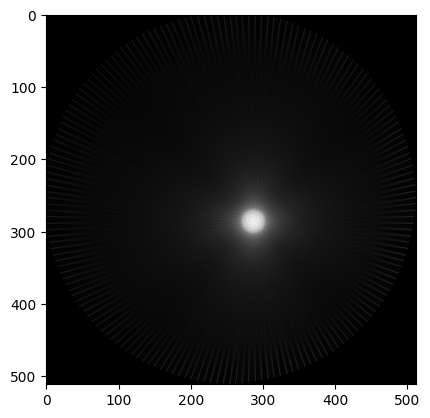

In [68]:
def choose_dicom_file():
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filename = filedialog.askopenfilename(initialdir=".", title="Wybierz obraz w formacie DICOM", filetypes=(("dicom files", ".dcm"), ("all files", ".")))
    %gui tk
    return filename

def load_dicom(filename):
    dicom_data = pydicom.dcmread(filename)
    image = dicom_data.pixel_array
    return dicom_data, image

def save_changes_and_display(filename, name, date, patient_id, comments, dicom_img):
    patient_data = {
        "PatientName": name.value,
        "StudyDate": date.value,
        "PatientID": patient_id.value,
        "ImageComments": comments.value
    }
    save_as_dicom(filename, dicom_img, patient_data)

dcm_file = choose_dicom_file()
data, dicom_img = load_dicom(dcm_file)

name = widgets.Text(
    value=str(data.PatientName),
    placeholder='Name and Surname',
    description='Name and Surname:',
    disabled=False   
)
date = widgets.Text(
    value=str(data.StudyDate),
    placeholder='Study date',
    description='Date of study:',
    disabled=False   
)
id = widgets.Text(
    value=str(data.PatientID),
    placeholder='Patient ID',
    description='Patient ID:',
    disabled=False   
)
comments = widgets.Text(
    value=str(data.ImageComments),
    placeholder='Comments',
    description='Comments:',
    disabled=False   
)
save_button = widgets.Button(description="Save Changes")

def on_save_button_click(b):
    save_changes_and_display(dcm_file, name, date, id, comments, dicom_img)
    
save_button.on_click(on_save_button_click)

# Display the widgets and button
display(widgets.VBox([name, date, id, comments, save_button]))
plt.imshow(dicom_img, cmap="gray")